In [1]:
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import numpy as np
from tqdm import tqdm

In [2]:
args={}
kwargs={}

args['batch_size']=1000
args['test_batch_size']=1000

In [3]:
train_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('/content/data', split='balanced', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['batch_size'], shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.EMNIST('/content/data', split='balanced', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=args['test_batch_size'], shuffle=True, **kwargs)


100%|██████████| 561753746/561753746 [00:17<00:00, 31638439.68it/s]


Extracting /content/data/EMNIST/raw/gzip.zip to /content/data/EMNIST/raw


In [4]:
for i, b in enumerate(test_loader):
  if i > 0:
    break
  print(len(b))
  print(b[0].shape)
  print(b[1].shape)

2
torch.Size([1000, 1, 28, 28])
torch.Size([1000])


In [5]:
class Net(nn.Module):
    def __init__(self, args=None):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(1, 10, kernel_size=5) # 1, 28, 28 -> # 10, 24, 24
        self.conv1_max_pool = nn.MaxPool2d(2) # 10, 12, 12
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5) # 10, 12, 12 -> 20, 8, 8 = 1280
        self.conv2_drop = nn.Dropout2d(inplace=True) # 20, 8, 8
        self.conv2_max_pool = nn.MaxPool2d(2) # 20, 4, 4 = 320
        self.fc1 = nn.Linear(320, 160)
        self.fc2 = nn.Linear(160, 47)
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()

        model = [
            self.conv1,
            self.conv1_max_pool,
            self.relu
        ]

        model += [
            self.conv2,
            self.conv2_drop,
            self.conv2_max_pool,
            self.relu
        ]

        model += [
            self.flatten,
            self.fc1,
            self.relu,
            self.fc2,
            nn.LogSoftmax(dim=1)
        ]

        self.model = nn.Sequential(*model)
        self.set_args(args)

    def forward(self, x):
      return self.model(x)

    def set_args(self, user_args):
      args={}
      args['batch_size']=1000
      args['test_batch_size']=1000
      args['epochs']=20
      args['lr']=0.01
      args['momentum']=0.5

      args['seed']=42
      args['log_interval']=10
      args['cuda']=True if torch.cuda.is_available() else False
      args['device'] = "cuda" if args['cuda'] else "cpu"

      args['optimizer'] = torch.optim.SGD(self.model.parameters(), lr=args['lr'], momentum=args['momentum'])
      args['loss_function'] = nn.NLLLoss()

      if user_args != None:
        args.update(user_args)
      self.args = args

In [6]:
def train_epoch(model, args):
  loader = args['train_loader']
  optimizer = args['optimizer']
  loss_function = args['loss_function']

  losses = []

  model.train()
  for i, (tensor, target) in tqdm(enumerate(loader)):
    optimizer.zero_grad()
    tensor = tensor.to(args['device'])
    target = target.to(args['device'])

    prediction = model(tensor)
    loss = loss_function(prediction, target)
    losses.append(loss.item())

    loss.backward()
    optimizer.step()

  return losses

def train(model):
  args = model.args
  epochs = args['epochs']
  model.to(args['device'])

  losses = []
  for epoch in range(epochs):
    loss_epoch = train_epoch(model, args)
    losses.append(np.mean(loss_epoch))
    print('{}: {}'.format(epoch, losses[-1]))

def test(model):
  losses = []
  model.eval()
  args = model.args
  loss_function = args['loss_function']
  loader = args['test_loader']

  acc_numerator = 0
  acc_denumerator = len(loader.dataset)

  model.to(args['device'])
  for tensor, target in loader:
    tensor = tensor.to(args['device'])
    target = target.to(args['device'])

    prediction = model(tensor)
    pred_argmax = prediction.argmax(dim=1)

    # print(pred_argmax.shape, target.shape)
    num_corrects = torch.sum((pred_argmax == target))
    acc_numerator += num_corrects

    loss = loss_function(prediction, target)

    losses.append(loss.item())

  print('Avg loss: {}, Acc: {}'.format(np.mean(losses), (acc_numerator / acc_denumerator)))

In [7]:
mynet = Net({'train_loader': train_loader, 'test_loader': test_loader})
mynet.args

{'batch_size': 1000,
 'test_batch_size': 1000,
 'epochs': 20,
 'lr': 0.01,
 'momentum': 0.5,
 'seed': 42,
 'log_interval': 10,
 'cuda': True,
 'device': 'cuda',
 'optimizer': SGD (
 Parameter Group 0
     dampening: 0
     differentiable: False
     foreach: None
     fused: None
     lr: 0.01
     maximize: False
     momentum: 0.5
     nesterov: False
     weight_decay: 0
 ),
 'loss_function': NLLLoss(),
 'train_loader': <torch.utils.data.dataloader.DataLoader at 0x7cd90835fa60>,
 'test_loader': <torch.utils.data.dataloader.DataLoader at 0x7cd90839dd20>}

In [8]:
train(mynet)

113it [00:26,  4.30it/s]


0: 3.816711235890346


113it [00:28,  4.00it/s]


1: 3.213011003173558


113it [00:24,  4.57it/s]


2: 2.0577339324276003


113it [00:24,  4.65it/s]


3: 1.666790219534815


113it [00:24,  4.68it/s]


4: 1.4838770416985572


113it [00:24,  4.64it/s]


5: 1.370328596207948


113it [00:25,  4.40it/s]


6: 1.2817063616440358


113it [00:25,  4.36it/s]


7: 1.2004669408882613


113it [00:24,  4.65it/s]


8: 1.1399154072314237


113it [00:24,  4.59it/s]


9: 1.0831264304903756


113it [00:24,  4.58it/s]


10: 1.039107855442351


113it [00:24,  4.59it/s]


11: 0.9985600625519204


113it [00:24,  4.59it/s]


12: 0.9568097232717329


113it [00:25,  4.38it/s]


13: 0.9254870024402585


113it [00:25,  4.48it/s]


14: 0.8966458239386567


113it [00:25,  4.48it/s]


15: 0.876664786739687


113it [00:24,  4.53it/s]


16: 0.8538773102042949


113it [00:24,  4.62it/s]


17: 0.8312082886695862


113it [00:24,  4.60it/s]


18: 0.816071207544445


113it [00:25,  4.43it/s]

19: 0.8003759373605779


In [9]:
test(mynet)

Avg loss: 0.6414582792081331, Acc: 0.7995744347572327


In [10]:
import matplotlib.pyplot as plt

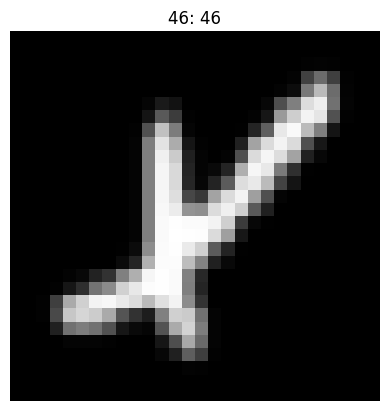

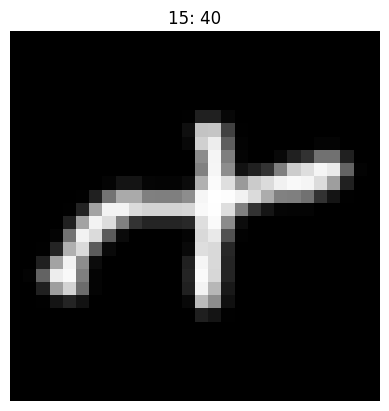

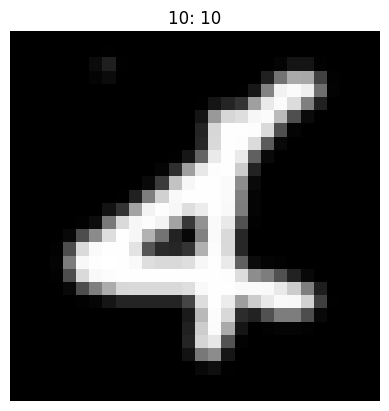

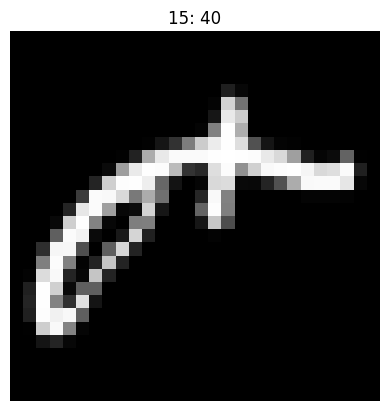

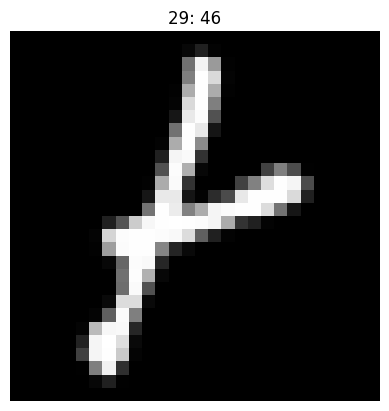

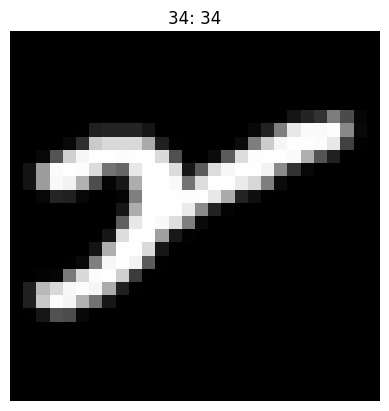

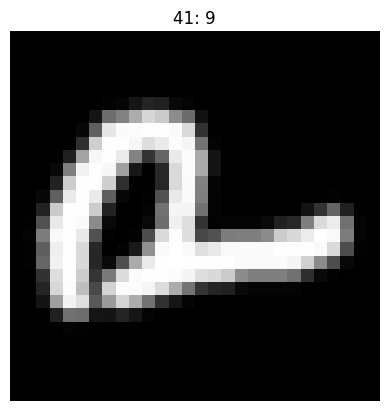

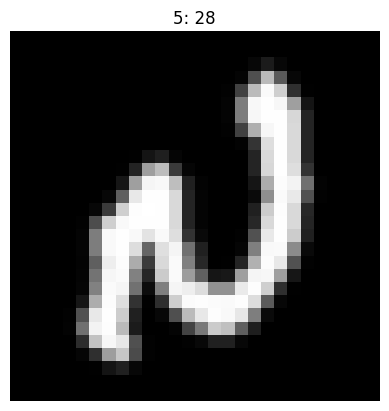

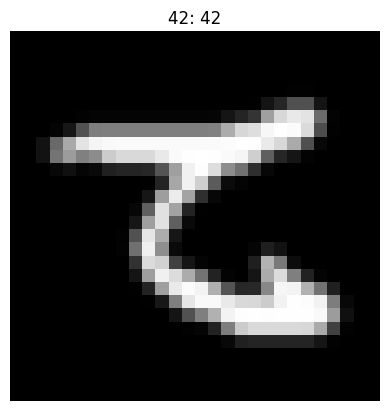

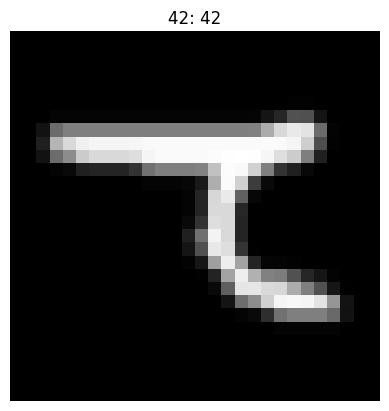

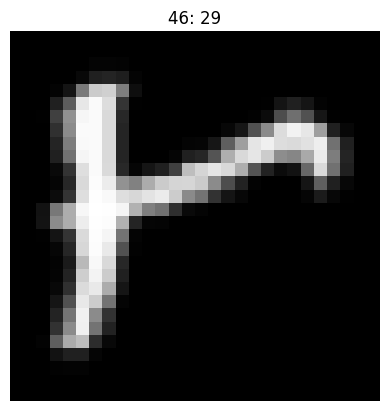

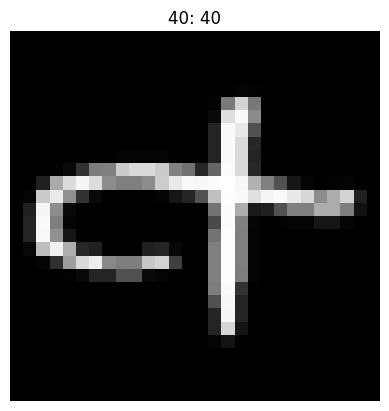

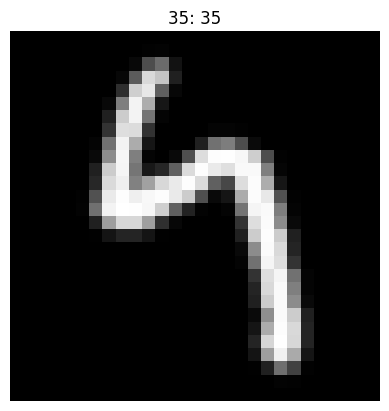

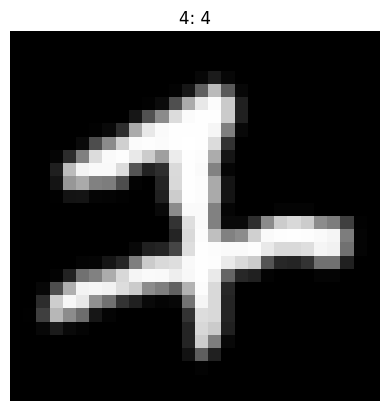

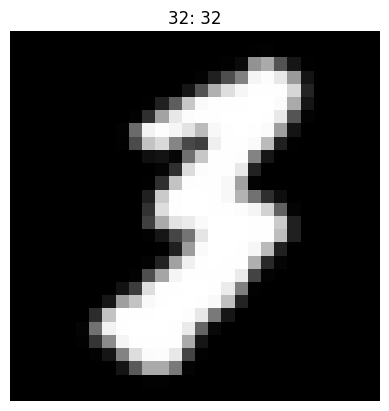

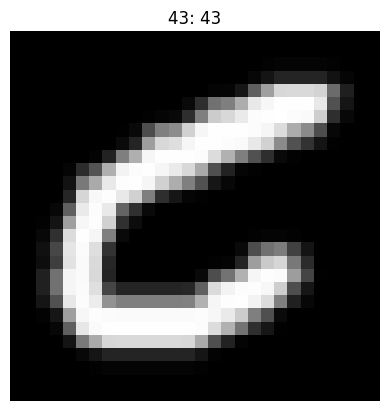

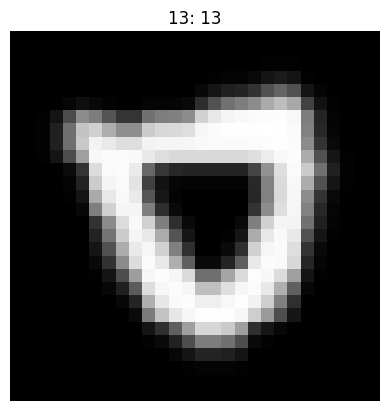

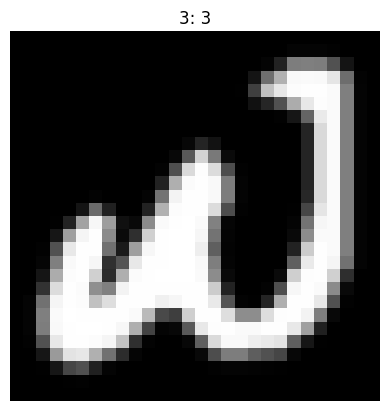

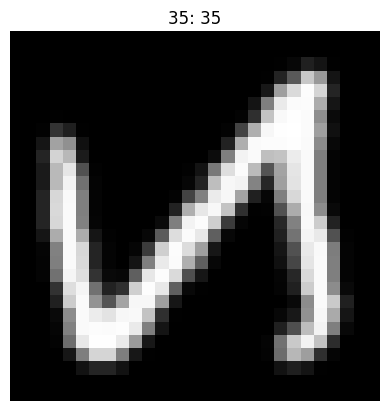

In [11]:
for i, (tensor, target) in enumerate(test_loader):
  if i > 100:
    break
  tensor = tensor.to(mynet.args['device'])
  prediction = mynet(tensor)

  image = tensor[0].squeeze(0)
  image_prediction = prediction[0].argmax()
  label = target[0]

  image_np = image.cpu().numpy()
  plt.imshow(image_np, cmap="gray")
  plt.title("{}: {}".format(label, image_prediction))
  plt.axis('off')
  plt.show()
